# Plot Cycles-L WE-38 watershed domain
Plot grid configuration, elevation, crop rotation, and soil types of the Cycles-L WE-38 watershed domain.
This Jupyter notebook requires the `PIHM-utils` Python package.

## Import and set plotting parameters

In [27]:
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from math import floor
from matplotlib import patheffects
from matplotlib.collections import LineCollection
from pihm import read_mesh
from pihm import read_river
from my_funcs import read_cycles
from setting import WE38_SHP

In [28]:
SMALL_SIZE = 14
TINY_SIZE = 12
MEDIUM_SIZE = SMALL_SIZE + 2
BIGGER_SIZE = MEDIUM_SIZE + 2

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Define functions

In [29]:
def read_attrib(simulation):
    filen = '../input/' + simulation + '/' + simulation + '.att'

    attribstr = []
    with open(filen) as file:
        for line in file:
            if line.strip() and line.strip()[0] != '#':
                attribstr.append(line.strip())

    soil = []
    lc = []
    meteo = []
    attribstr.pop(0)
    for line in attribstr:
        strs = line.split()[1:5]
        soil.append(int(strs[0]))
        lc.append(int(strs[2]))
        meteo.append(int(strs[3]))

    return np.array(soil), np.array(lc), np.array(meteo)


def utm_from_lon(lon):
    """
    utm_from_lon - UTM zone for a longitude

    Not right for some polar regions (Norway, Svalbard, Antartica)

    :param float lon: longitude
    :return: UTM zone number
    :rtype: int
    """
    return floor((lon + 180) / 6) + 1

def scale_bar(ax, proj, length,
    location=(0.5, 0.05),
    linewidth=3,
    units='km',
    m_per_unit=1000
    ):
    """

    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle
    of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    matplotlib.rc('font', family='DejaVu Sans')
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit/2, sbcx + length * m_per_unit/2]
    # buffer for scalebar
    buffer = [patheffects.withStroke(linewidth=5, foreground="w")]
    # Plot the scalebar with buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k', linewidth=linewidth, path_effects=buffer)
    # buffer for text
    buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
    # Plot the scalebar label
    t0 = ax.text(sbcx, sbcy, str(length) + ' ' + units,
        transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    left = x0+(x1-x0)*0.05
    # Plot the N arrow
    t1 = ax.text(left, sbcy, u'\u25b2\nN', transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    # Plot the scalebar without buffer, in case covered by text buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, zorder=3)


def make_map(fig, projection):
    extent = [-76.613, -76.573, 40.701, 40.736]
    ax = fig.add_axes([0.025, 0.08, 0.25, 0.85], projection=projection)
    gl = ax.gridlines(
        draw_labels=True,
        xlocs=[-76-36/60, -76-35/60],
        ylocs=[40+42/60, 40+43/60, 40+44/60],
        dms=True,
        alpha=0.5,
        linestyle='--')
    gl.top_labels = gl.right_labels = False
    ax.set_extent(extent)

    return ax

/usr/local/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:801: UserWarning: Approximating coordinate system <Geographic 3D CRS: GEOGCRS["unknown",DATUM["unknown",ELLIPSOID["WGS 8 ...>
Name: unknown
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
- h[up]: Ellipsoidal height (metre)
Area of Use:
- undefined
Datum: unknown
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
 with the PlateCarree projection.
  warnings.warn(f'Approximating coordinate system {crs!r} with '


Text(0.77, 0.95, '(d)')

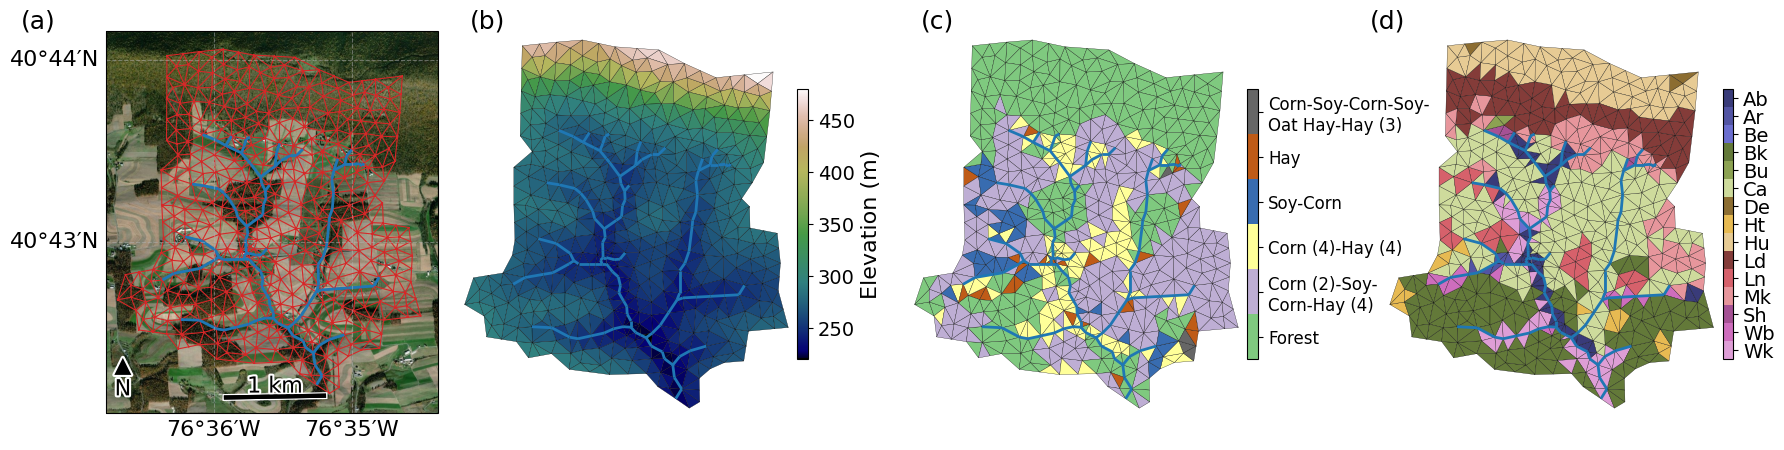

In [30]:
url = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}.jpg'
request = cimgt.GoogleTiles(url=url)

fig = plt.figure(figsize=(18, 4.5))
ax = make_map(fig, projection=request.crs)
ax.add_image(request, 15)

t = gpd.read_file(WE38_SHP)
num_elem, _, tri, x, y, _, zmax = read_mesh('../', 'WE38')
num_river, from_node, to_node, _ = read_river('../', 'WE38')
soil, _, _ = read_attrib('WE38')

coord = ccrs.PlateCarree().transform_points(t.crs, x, y)
lons = coord[:, 0]
lats = coord[:, 1]

ax.triplot(lons, lats, tri,
    color='tab:red',
    lw=0.8,
    transform=ccrs.PlateCarree(),
)

## Create line collection of river segments for plotting
lines = [[(lons[from_node[i]], lats[from_node[i]]), (lons[to_node[i]], lats[to_node[i]])] for i in range(num_river)]
river_segments = LineCollection(lines, linewidths=2, colors='tab:blue',
    linestyle='solid',
    transform=ccrs.PlateCarree(),
    )
ax.add_collection(river_segments)

scale_bar(ax, ccrs.PlateCarree(), 1)  # 100 km scale bar


# Elevation
elev = np.average(zmax[tri], axis=1)

## Create line collection of river segments for plotting
lines = [[(x[from_node[i]], y[from_node[i]]), (x[to_node[i]], y[to_node[i]])] for i in range(num_river)]
river_segments = LineCollection(lines,
    linewidths=2,
    colors='tab:blue',
    linestyle='solid',
    )

ax = fig.add_axes([0.222, 0.05, 0.25, 0.9])

tpc = ax.tripcolor(x, y, tri,
    facecolors=elev,
    edgecolors='k',
    lw=0.2,
    cmap='gist_earth',
)

ax.add_collection(river_segments)
ax.set_aspect('equal')
cbaxes = fig.add_axes([0.442, 0.2, 0.006, 0.6])
cbar = fig.colorbar(tpc, shrink=0.8, cax=cbaxes)
cbar.set_label(label=r'Elevation (m)')
ax.axis('off')

# Management
_, mgmt = read_cycles('WE38')

mgmt[(mgmt == 3) | (mgmt == 4) | (mgmt == 5)] = 2
mgmt[(mgmt == 6) | (mgmt == 7)] = 3
mgmt[(mgmt == 8) | (mgmt == 9)] = 4
mgmt[(mgmt == 10)] = 5
mgmt[(mgmt == 11)] = 6

ax = fig.add_axes([0.472, 0.05, 0.25, 0.9])

tpc = ax.tripcolor(x, y, tri,
    facecolors=mgmt,
    vmin=0.5,
    vmax=6.5,
    edgecolors='k',
    lw=0.2,
    cmap=plt.get_cmap('Accent', 6)
    )

river_segments = LineCollection(lines,
    linewidths=2,
    colors='tab:blue',
    linestyle='solid',
)
ax.add_collection(river_segments)
ax.set_aspect('equal')
ax.axis('off')

## Add color bar with variable name and unit
cbaxes = fig.add_axes([0.692, 0.20, 0.006, 0.6])
cbar = fig.colorbar(
    tpc,
    cax=cbaxes,
)

rotations = [
    'Forest',
    'Corn (2)-Soy-\nCorn-Hay (4)',
    'Corn (4)-Hay (4)',
    'Soy-Corn',
    'Hay',
    'Corn-Soy-Corn-Soy-\nOat Hay-Hay (3)',
]
cbar.set_ticks(range(1, 7))
cbar.set_ticklabels(rotations, fontsize=TINY_SIZE)

# Soil
soil[soil == 5] = 4
soil[soil == 6] = 4
for st in range(7, 18):
    soil[soil == st] = st - 2

ax = fig.add_axes([0.736, 0.05, 0.25, 0.9])
tpc = ax.tripcolor(x, y, tri,
    facecolors=soil,
    edgecolors='k',
    vmin=0.5,
    vmax=15.5,
    lw=0.2,
    cmap=plt.get_cmap('tab20b', 15),
)
river_segments = LineCollection(lines,
    linewidths=2,
    colors='tab:blue',
    linestyle='solid',
    )
ax.add_collection(river_segments)
ax.set_aspect('equal')
plt.axis('off')

## Add color bar with variable name and unit
cbaxes = fig.add_axes([0.956, 0.20, 0.006, 0.6])
cbar = fig.colorbar(
    tpc,
    #shrink=0.5,
    cax=cbaxes,
)

soils = [
    "Ab",
    "Ar",
    "Be",
    "Bk",
    #"BkC",
    #"BkD",
    "Bu",
    "Ca",
    "De",
    "Ht",
    "Hu",
    "Ld",
    "Ln",
    "Mk",
    "Sh",
    "Wb",
    "Wk",
]
cbar.set_ticks(range(1, 16))
cbar.set_ticklabels(soils)
cbar.ax.invert_yaxis()

fig.text(0.02, 0.95,'(a)', ha='center', va='center', size=BIGGER_SIZE, transform=plt.gcf().transFigure)
fig.text(0.27, 0.95,'(b)', ha='center', va='center', size=BIGGER_SIZE, transform=plt.gcf().transFigure)
fig.text(0.52, 0.95,'(c)', ha='center', va='center', size=BIGGER_SIZE, transform=plt.gcf().transFigure)
fig.text(0.77, 0.95,'(d)', ha='center', va='center', size=BIGGER_SIZE, transform=plt.gcf().transFigure)

#plt.savefig('domain.pdf', dpi=300)
#plt.savefig('domain.png', dpi=300)